In [1]:
import os, sys

import numpy as np
import matplotlib.pyplot as plt

from scipy.special import logit
from scipy.special import expit as sigmoid

In [2]:
from optim import Problem
# from optim.utils import unpack_bounds
from optim.solver.gradient import SolverGradient

In [3]:
class ParametrizationIdentity:
    def __init__(self):
        pass
        
    def __call__(self, x):
        return x
    
    def inverse(self, x):
        return x


class ParametrizationExp:
    def __init__(self):
        pass
        
    def __call__(self, x):
        return -np.exp(x)
    
    def inverse(self, x):
        return np.log(-x + 1e-300)
    
    
class ParametrizationLogit:
    def __init__(self):
        from scipy.optimize import Bounds
        self.bounds = Bounds(0, 1, keep_feasible=True)
        
    def __call__(self, x):
        return logit(x)
    
    def inverse(self, x):
        return sigmoid(x)

In [4]:
# Rosenbrock function

b = 10
function_to_minimize = lambda x: (x[0] - 1)**2 + b * (x[1] - x[0]**2)**2

In [5]:
class ProblemRosenbrock(Problem):
    def __init__(self):
        super().__init__()
        
    def objective(self, x):
        return function_to_minimize(x)

In [6]:
problem = ProblemRosenbrock()

# parametrization = None
# parametrization = ParametrizationIdentity()
# parametrization = ParametrizationExp()
parametrization = ParametrizationLogit()
bounds = parametrization.bounds

problem.set_parametrization(parametrization)

# bounds = []
# bounds = [(-np.inf, 0), (-np.inf, 0)]

problem.add_bounds(bounds)

solver = SolverGradient(problem)
solver.prepare(method="trust-constr", maxiter=100)

x_init = np.array([-1, -1])

x_sol = solver.solve(parametrization.inverse(x_init), seed=42)
x_sol = parametrization(x_sol)
print(x_sol)

`gtol` termination condition is satisfied.
Number of iterations: 34, function evaluations: 81, CG iterations: 47, optimality: 6.62e-10, constraint violation: 0.00e+00, execution time: 0.11 s.
Success: True
[0.9999968  0.99999353]


In [7]:
x_range = (-2, 3)
y_range = (-2, 6)

X = np.arange(*x_range, step=0.1)
Y = np.arange(*y_range, step=0.1)

X, Y = np.meshgrid(X, Y)
Z = function_to_minimize([X, Y])

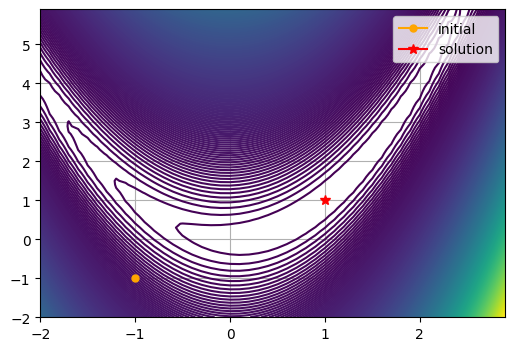

In [8]:
plt.figure(figsize=(6, 4));

plt.contour(X, Y, Z, levels=500);

plt.plot([x_init[0]], [x_init[1]], marker="o", markersize=5, color="orange", label="initial");
plt.plot([x_sol[0]], [x_sol[1]], marker="*", markersize=7, color="red", label="solution");
plt.legend();
plt.grid();